[*********************100%***********************]  1 of 1 completed


Shape: (1738, 1)
Epoch 1/100


c:\Users\borys\OneDrive\Documents\Projects\Python\Stock-Prediction-DeepLearning\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0082 - val_loss: 8.9892e-04 - learning_rate: 0.0100
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5659e-04 - val_loss: 4.3273e-04 - learning_rate: 0.0100
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5705e-04 - val_loss: 5.3732e-04 - learning_rate: 0.0100
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3276e-04 - val_loss: 4.2128e-04 - learning_rate: 0.0100
Epoch 5/100
32/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4711e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5086e-04 - val_loss: 4.8989e-04 - learning_rate: 0.0100
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4825e-04 - val_loss: 5.0379e-04 - learning_rate: 0.0050
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1949e-04 - val_loss: 3.6687e-04 - learning_rate: 0.0050
Epoch 8/100
32/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.62

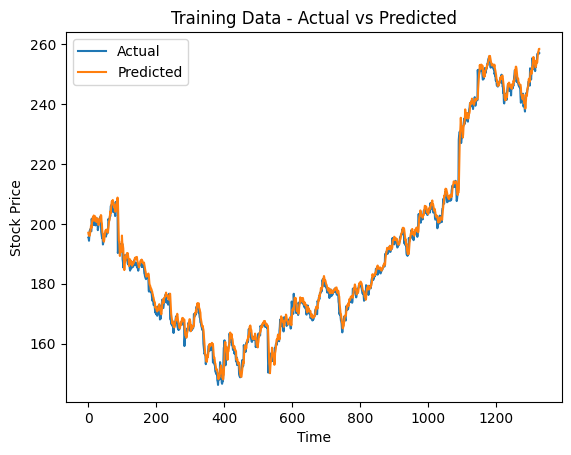

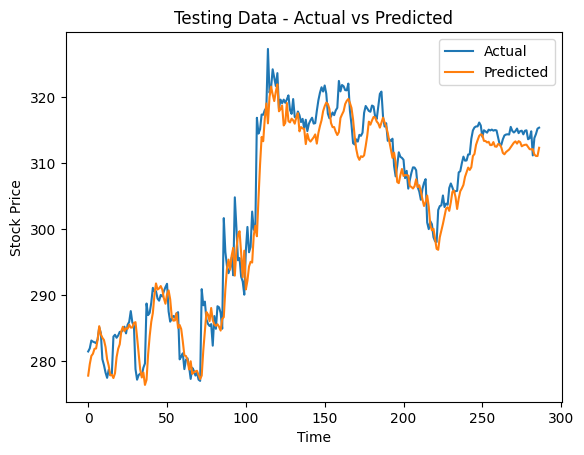

In [29]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

# Download historical stock data (e.g., Apple)
data = yf.download("GOOG", period='1y', interval='1h', auto_adjust=True)
data = data[["Close"]]  # Use only closing price

# Normalize data
scaler = MinMaxScaler()
data["Close"] = scaler.fit_transform(np.array(data["Close"]).reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

print("Shape:", data.shape)

# Create dataset with lookback period (e.g., 60 days)
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset['Close'][i:(i + look_back)].values  # Access 'Close' column and convert to NumPy array
        X.append(a)
        # Access 'Close' column by name using .iloc for integer-based indexing
        Y.append(dataset['Close'].iloc[i + look_back])  
    return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


model = Sequential()
model.add(SimpleRNN(units=128, return_sequences=False, input_shape=(X_train.shape[1], 1)))
# model.add(Dropout(0.2))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1))

# Compile model
optimizer = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)

# Train model
history = model.fit(X_train, 
          Y_train, 
          epochs=100, 
          batch_size=32, 
          callbacks=[early_stop, lr_scheduler],
          validation_data=(X_test, Y_test),
          verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))  # Reshape Y_train before inverse transform
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape Y_test before inverse transform

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Calculate root mean squared error (RMSE)
train_rmse = math.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(Y_test, test_predict))
print('Train RMSE: %.3f' % (train_rmse))
print('Test RMSE: %.3f' % (test_rmse))

# Calculate mean absolute error (MAE)
train_mae = mean_absolute_error(Y_train, train_predict)
test_mae = mean_absolute_error(Y_test, test_predict)
print('Train MAE: %.3f' % (train_mae))
print('Test MAE: %.3f' % (test_mae))

# Plot the results
import matplotlib.pyplot as plt

# Plot the training data and predictions
plt.plot(Y_train, label='Actual')
plt.plot(train_predict, label='Predicted')
plt.title('Training Data - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot the testing data and predictions
plt.plot(Y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Testing Data - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

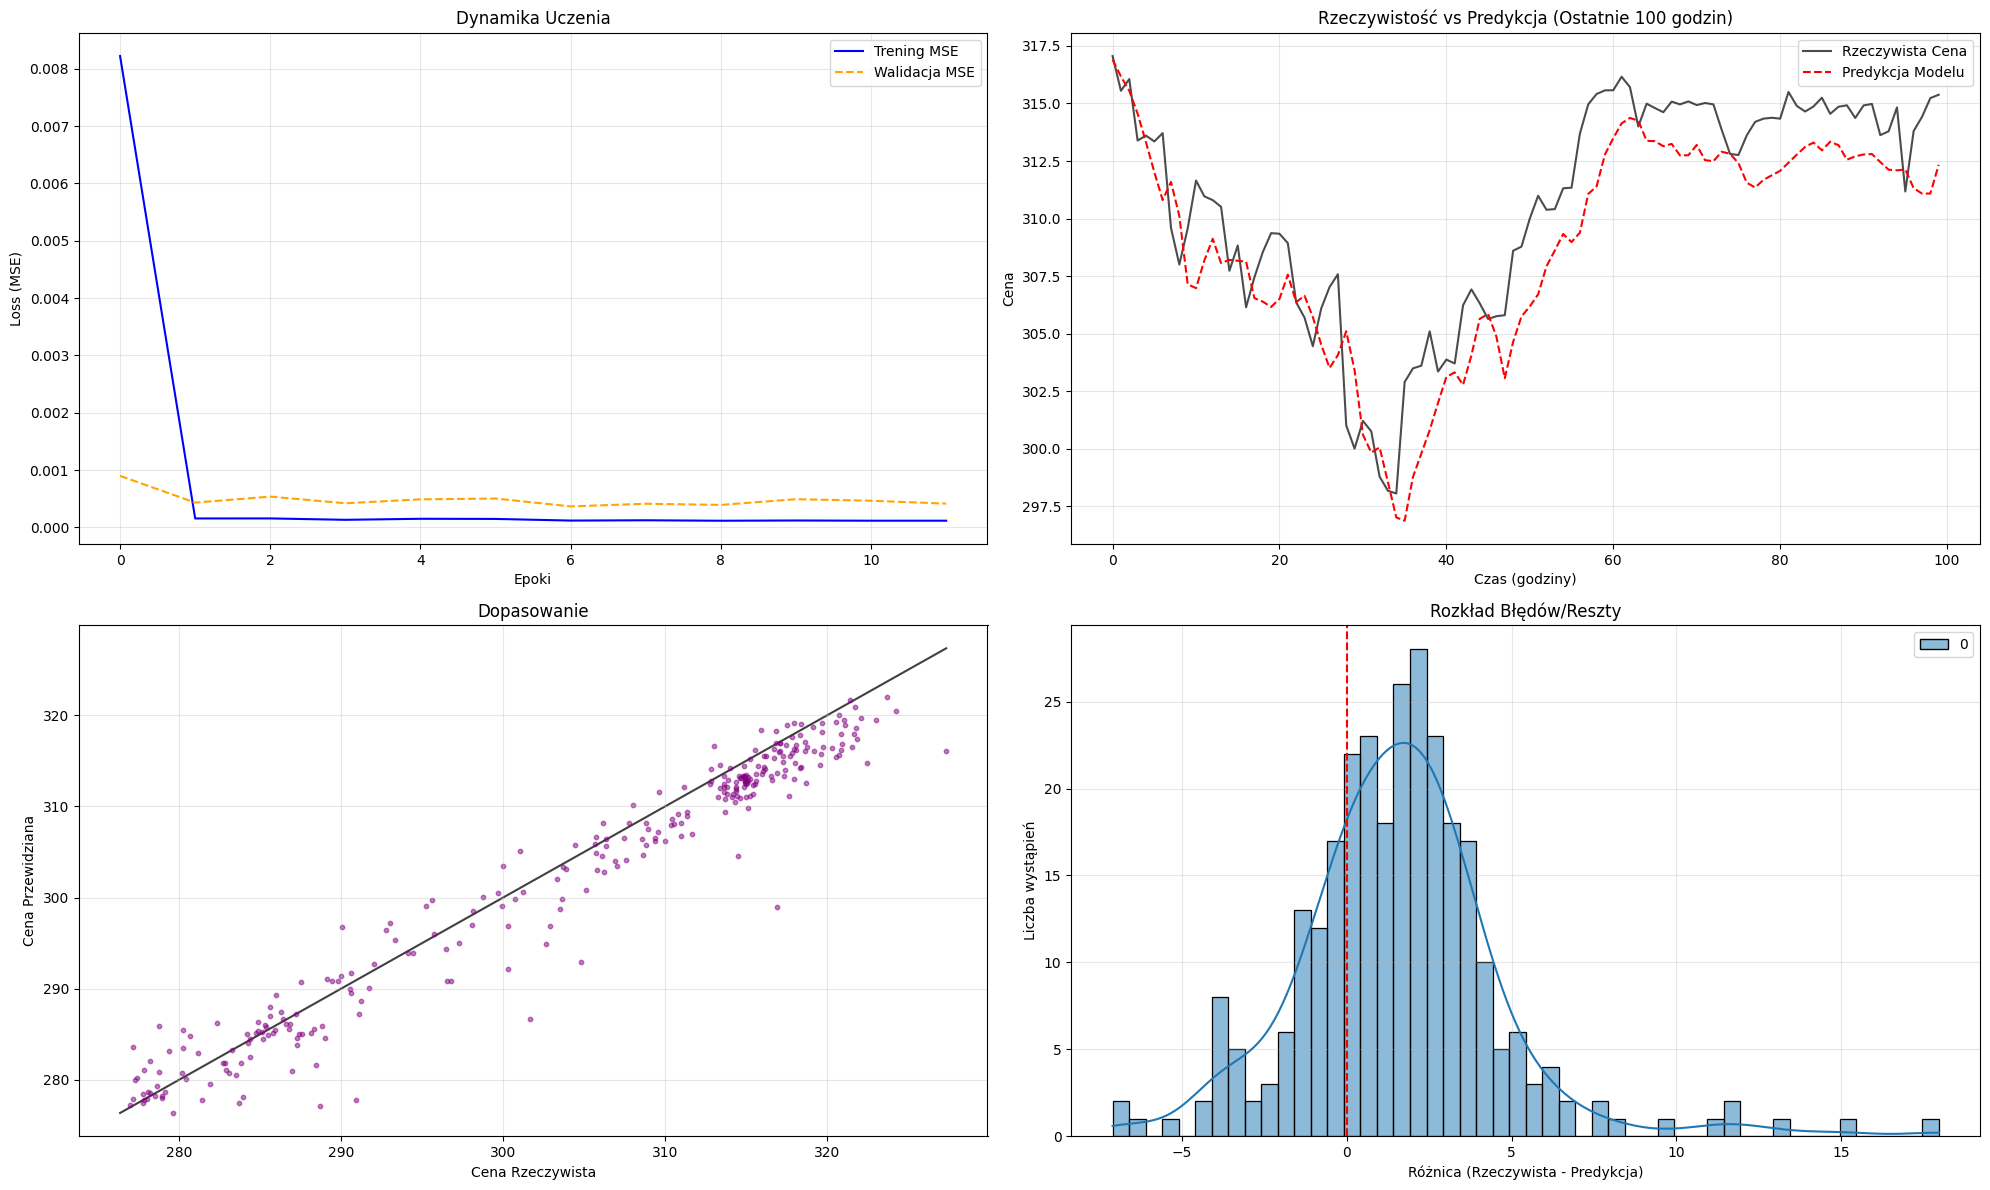

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Przygotowanie danych "po fakcie"
# Pobieramy historię z obiektu Keras (standardowego)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Obliczamy reszty (błędy)
residuals = Y_test - test_predict

# --- TWORZENIE WYKRESÓW ---
plt.figure(figsize=(20, 12))

# WYKRES 1
plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Trening MSE', color='blue')
plt.plot(val_loss, label='Walidacja MSE', color='orange', linestyle='--')
plt.title('Dynamika Uczenia')
plt.xlabel('Epoki')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# WYKRES 2
limit = 100
plt.subplot(2, 2, 2)
plt.plot(Y_test[-limit:], label='Rzeczywista Cena', color='black', alpha=0.7)
plt.plot(test_predict[-limit:], label='Predykcja Modelu', color='red', linestyle='--')
plt.title(f'Rzeczywistość vs Predykcja (Ostatnie {limit} godzin)')
plt.xlabel('Czas (godziny)')
plt.ylabel('Cena')
plt.legend()
plt.grid(True, alpha=0.3)

# WYKRES 3
plt.subplot(2, 2, 3)
plt.scatter(Y_test, test_predict, alpha=0.5, s=10, color='purple')
# Rysujemy idealną linię przekątną
lims = [np.min([Y_test, test_predict]), np.max([Y_test, test_predict])]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.title('Dopasowanie')
plt.xlabel('Cena Rzeczywista')
plt.ylabel('Cena Przewidziana')
plt.grid(True, alpha=0.3)

# WYKRES 4
plt.subplot(2, 2, 4)
sns.histplot(residuals, kde=True, color='green', bins=50)
plt.axvline(x=0, color='red', linestyle='--') # Linia zerowa
plt.title('Rozkład Błędów/Reszty')
plt.xlabel('Różnica (Rzeczywista - Predykcja)')
plt.ylabel('Liczba wystąpień')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()